In [1]:
import numpy as np

from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Реализация библиотечной логистической регрессии

Подгрузим данные из библиотеки `scikit-learn`. Будем работать с классическим датасетом, содержащим информацию об ирисах Фишера, который часто используется как учебный пример в машинном обучении.

In [2]:
df = load_iris(as_frame=True).frame

df.sample(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
146,6.3,2.5,5.0,1.9,2
115,6.4,3.2,5.3,2.3,2
82,5.8,2.7,3.9,1.2,1
122,7.7,2.8,6.7,2.0,2
125,7.2,3.2,6.0,1.8,2


Посмотрим, сколько экземпляров каждого класса содержится в таргете.

In [3]:
df['target'].value_counts()

target
0    50
1    50
2    50
Name: count, dtype: int64

Сформируем новое поле `target_virginica`, которое будет равно 0, если цветок не является классом 2, иначе — 1. Старый таргет удалим.

In [4]:
df['target_virginica'] = df['target'].apply(lambda x: 1 if x == 2 else 0)

df.drop('target', axis=1, inplace=True)

df.sample(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target_virginica
125,7.2,3.2,6.0,1.8,1
122,7.7,2.8,6.7,2.0,1
123,6.3,2.7,4.9,1.8,1
30,4.8,3.1,1.6,0.2,0
27,5.2,3.5,1.5,0.2,0


Рассчитаем снова количество объектов каждого класса, чтобы убедиться, что все преобразования были сделаны корректно.

In [5]:
df['target_virginica'].value_counts()

target_virginica
0    100
1     50
Name: count, dtype: int64

Разделим датасет на обучающую и валидационную части.

In [6]:
features_train, features_val, target_train, target_val = train_test_split(df.drop('target_virginica', axis=1),
                                                                          df['target_virginica'],
                                                                          random_state=5,
                                                                          test_size=0.3)

Обучим модель и сделаем прогнозы на валидационной выборке.

In [7]:
model = LogisticRegression()

model.fit(features_train, target_train)

predictions_val = model.predict(features_val)

Оценим качество модели, выведя матрицу ошибок для прогнозов.

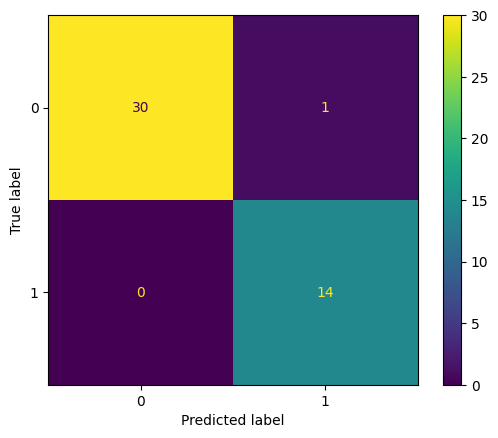

In [8]:
ConfusionMatrixDisplay(confusion_matrix(target_val, predictions_val)).plot();

Модель демонстрирует высокую производительность, только одно предсказание является ложноположительным (`FP`), остальные — верны.

# Реализация собственной логистической регрессии

Сконструируем класс `MyLogisticRegression`, решающий задачу логистической регрессии методом градиентного спуска.

In [9]:
class MyLogisticRegression:
    
    # Инициализатор класса, который позволит задать значения для полей объекта
    # step_size (величина шага) и iterations (количество итераций) при его создании.
    def __init__(self, step_size, iterations) -> None:
        self.step_size = step_size
        self.iterations = iterations
        
    # Функция сигмоида для нормализации прогнозов
    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))
    
    # Обучение модели на тренировочных данных  
    def fit(self, features_train, target_train):
        X = np.concatenate((np.ones((features_train.shape[0], 1)), features_train), axis=1) # Матрица признаков
        y = target_train # Вектор целевых значений
        w = np.zeros(X.shape[1]) # Вектор весов
        
        # Нахождение весов методом градиентного спуска
        for i in range(self.iterations):
            gradient = X.T @ (self.sigmoid(X @ w) - y) / X.shape[0] # Находим градиент функции потерь
            w -= self.step_size * gradient # Меняем веса в соответствии с градиентом
            
        self.w = w[1:] # Вектор весов
        self.w0 = w[0] # Свободный параметр
        
    # Предсказание вероятностей принадлежности к классу 1
    def predict(self, features_val):
        predictions_val = self.sigmoid(features_val.dot(self.w) + self.w0) #  Рассчитываем вероятности
        
        predictions_val[predictions_val > 0.5] = 1 # Возвращаем лейбл 1, если вероятность принадлежности к классу больше 0.5
        predictions_val[predictions_val <= 0.5] = 0 # Возвращаем лейбл 0, если вероятность принадлежности к классу меньше либо равна 0.5
        
        return predictions_val

Обучим собственную модель и сделаем прогнозы на валидационной выборке.

In [10]:
def make_predictions(step_size, iterations):
    my_model = MyLogisticRegression(step_size, iterations)
    my_model.fit(features_train, target_train)
    predictions_val = my_model.predict(features_val)
    
    return predictions_val
    

predictions_val = make_predictions(0.5, 100)

Оценим качество нашей модели, выведя матрицу ошибок для прогнозов.

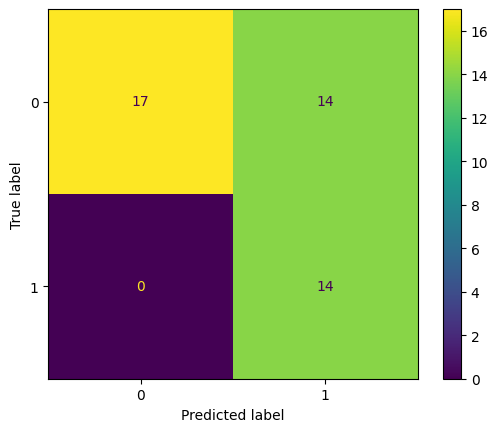

In [11]:
ConfusionMatrixDisplay(confusion_matrix(target_val, predictions_val)).plot();

При определении класса наша модель допускает много ошибок. Это происходит из-за неправильно подобранных параметров для метода градиентного спуска. Попробуем поварьировать параметры.

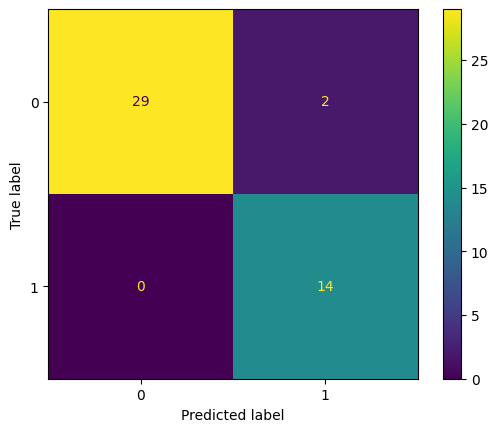

In [12]:
predictions_val = make_predictions(0.5, 1000)

ConfusionMatrixDisplay(confusion_matrix(target_val, predictions_val)).plot();

Повышение количества итераций значительно улучшило качество модели, однако оно все еще не достигает уровня качества библиотечной модели.

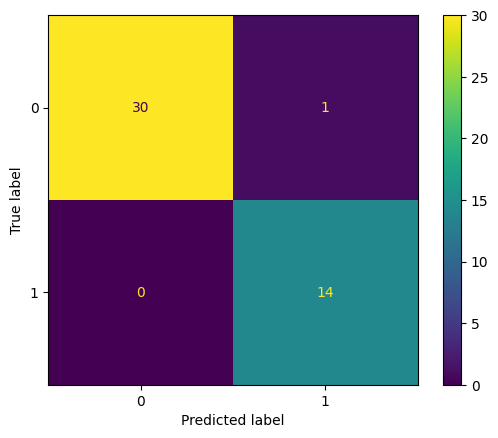

In [13]:
predictions_val = make_predictions(2, 1000)

ConfusionMatrixDisplay(confusion_matrix(target_val, predictions_val)).plot();

Увеличение значения шага градиентного спуска позволило достичь аналогичного качества модели, как у библиотечной.

# Вывод

В процессе работы было выполнено несколько шагов: загрузка данных из библиотеки `scikit-learn`, разбиение датасета на тренировочную и валидационную выборки, создание своей модели логистической регрессии для решения задачи классификации, подбор параметров для этой модели и сравнительный анализ ее результатов с библиотечной моделью.